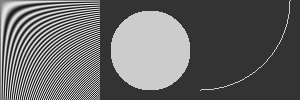

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, convolve2d

import PIL.Image
from io import BytesIO
import IPython.display

S = 100
def freqs(i, j):
    t = i / S
    f = j / 2.0
    v = np.sin(t * f * 2 * np.pi)
    return v * 0.4 + 0.5

def circle(i, j):
    dist = np.sqrt((i - S / 2) ** 2 + (j - S / 2) ** 2)
    return np.clip((dist < S * 0.4).astype(float), 0.2, 0.8)

def curve(i, j):
    W  = S * 0.9
    x = i / W
    y = j / W
    # x**2 + y ** 2 = 1 => y = sqrt(1 - x**2) or x = sqrt(1 - y**2)
    if i < j:
        if 1 - x**2 < 0.0:
            v = 0.0
        else:
            v =  float(j == int(np.sqrt(1 - x**2)*W))
    else:
        if 1 - y**2 < 0.0:
            v = 0.0
        else:
            v =  float(i == int(np.sqrt(1 - y**2)*W))  
    return np.clip(v, 0.2, 0.8)

def show_image(a):
    a = np.uint8(np.clip(a*255.0, 0., 255.))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, 'png')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

freq_image = np.fromfunction(freqs, (S,S), dtype=float)
circle_image = np.fromfunction(circle, (S,S), dtype=float)
curve_image = np.fromfunction(np.vectorize(curve), (S,S), dtype=float)

image = np.concatenate((freq_image, circle_image, curve_image), axis=1)

show_image(image)

def freq_response_window(window, cutoff):
    # Normalize window
    window = window * (1/sum(window))

    # Plot window
    x = np.arange(0,len(window), 1)
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12,3))

    ax1.plot(x, window)
    ax1.set_ylim(min(min(window), 0), max(window)+0.1)

    # Plot Frequency response
    w, h = freqz(window)

    m = np.abs(h)
    m_db = 20 * np.log10(m)

    ax2.plot(w, m_db)

    # Stack plot of aliased frequencies
    N = len(w) // cutoff

    layers = []
    remain = m

    while len(remain) > 0:
        layer = remain[:N].copy()
        layer.resize(N, refcheck=False)
        if len(layers) % 2 == 1:
            layer = np.flip(layer)
        
        layers.append(layer)
        remain = remain[N:]

    y = np.vstack(layers)
    ax3.stackplot(w[:N], y)

    plt.show()

    # Apply filter to image
    window = window[:, np.newaxis] # 2d kernel
    window = window @ window.T # square kernel
    window = window * (1.0/np.sum(window)) # renormalize
    image_response = convolve2d(image, window,mode='same')
    show_image(image_response)
    show_image(image_response[::cutoff, ::cutoff]) # downsampled

Box filter 2x


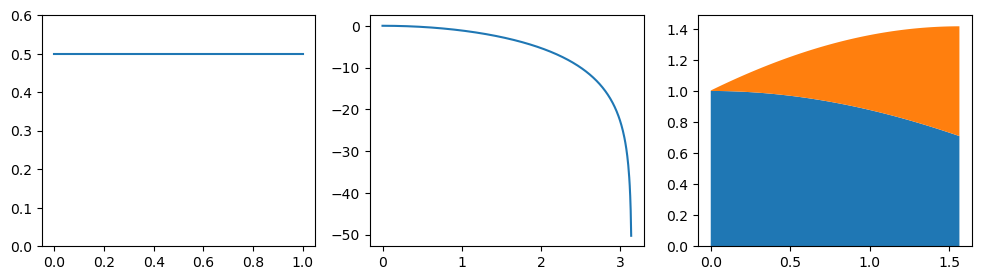

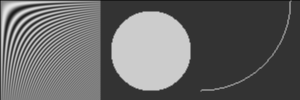

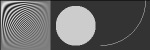

Box filter 3x


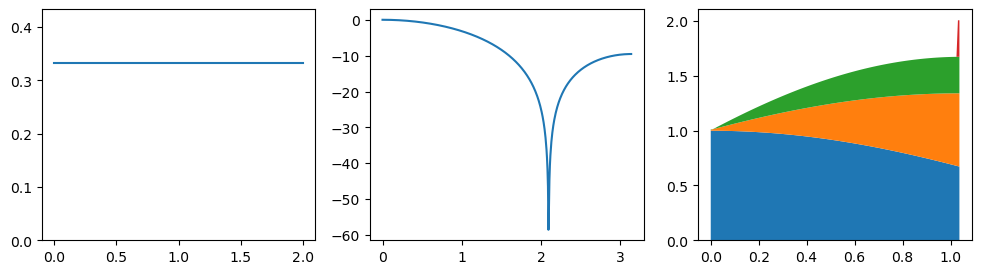

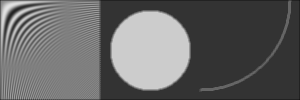

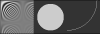

Lanczos 2x
3


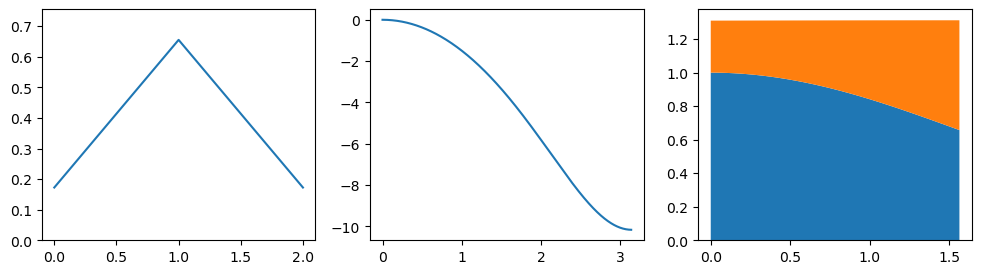

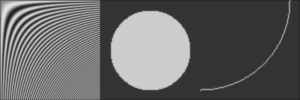

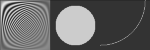

5


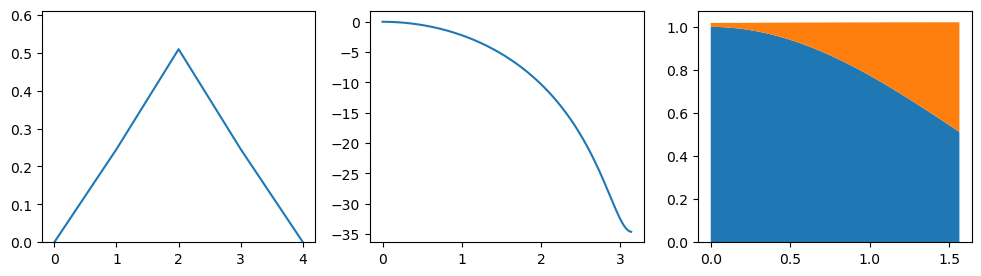

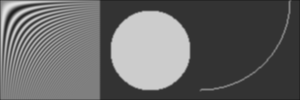

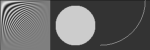

7


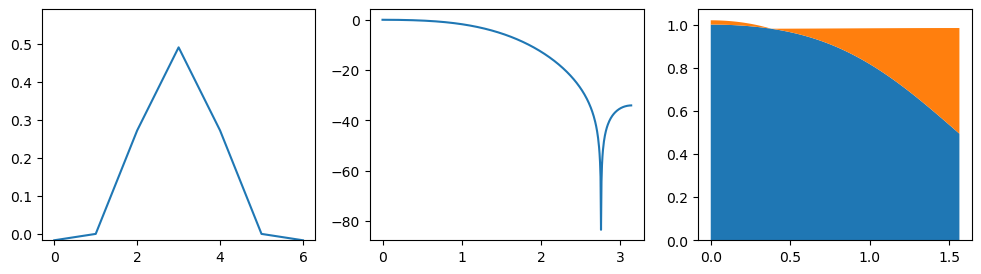

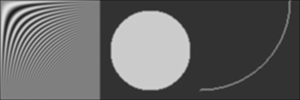

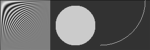

9


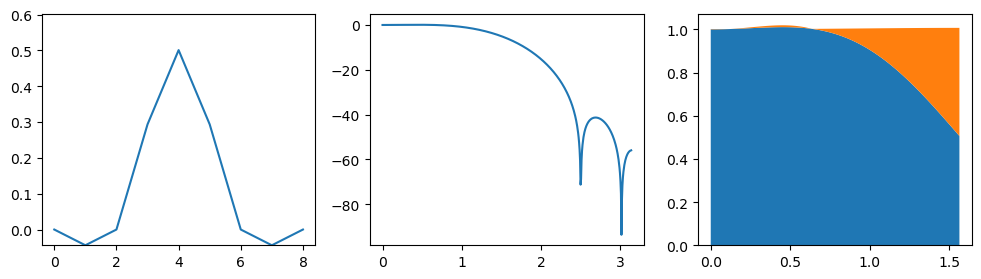

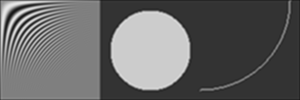

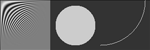

15


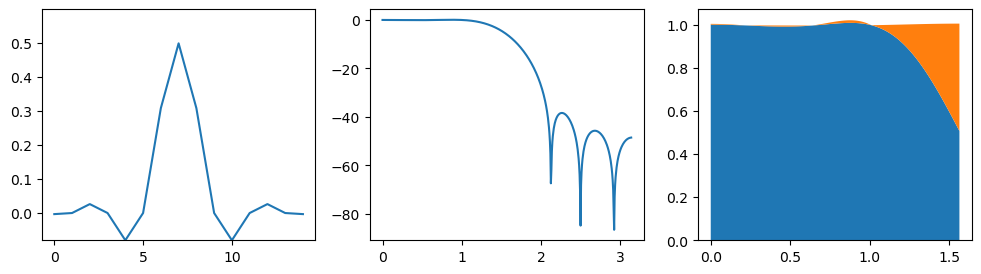

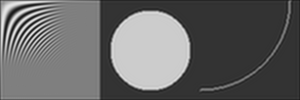

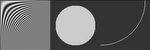

31


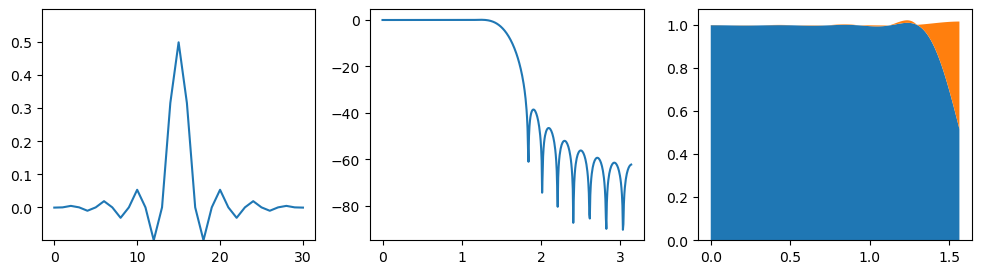

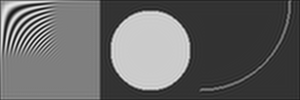

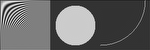

Lanczos 3x
5


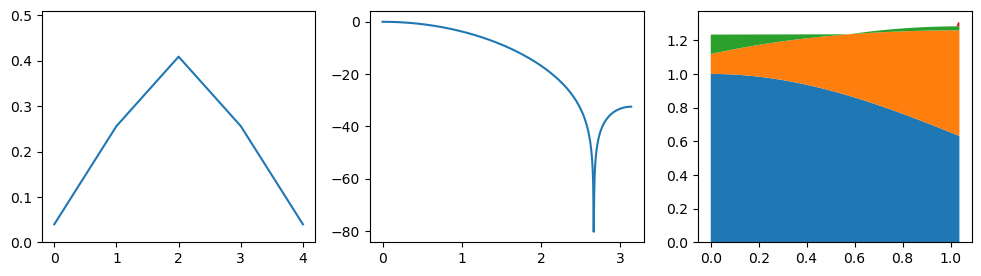

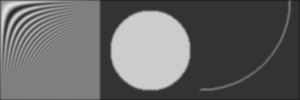

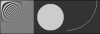

9


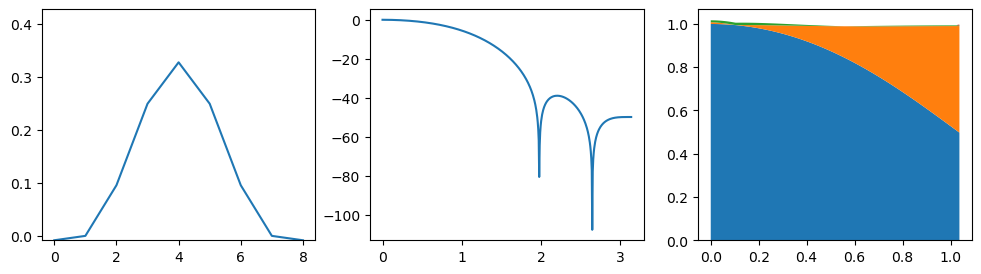

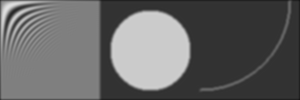

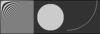

15


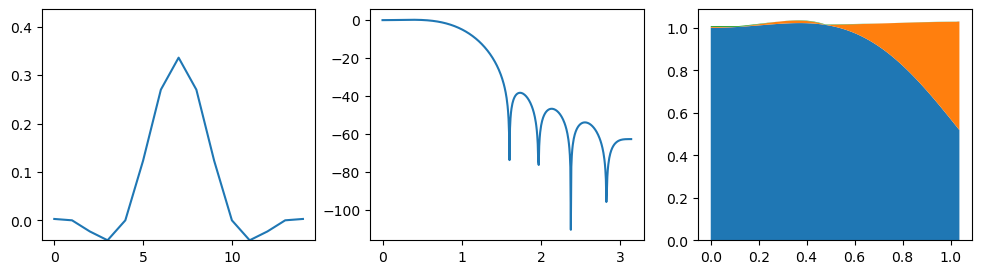

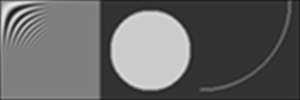

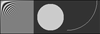

31


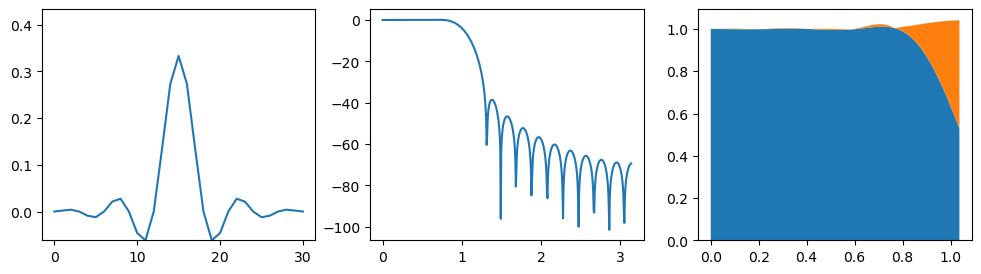

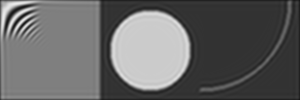

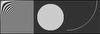

In [39]:
print('Box filter 2x')
freq_response_window(np.ones(2), 2)

print('Box filter 3x')
freq_response_window(np.ones(3), 3)

def lanczos_filter(width, a=3):
    half_width = width // 2
    x = np.linspace(-half_width, half_width, width)
    return np.sinc(x / a) * np.sinc(x / (width / 2))

print('Lanczos 2x')
print('3')
freq_response_window(lanczos_filter(3, 2), 2)
print('5')
freq_response_window(lanczos_filter(5, 2), 2)
print('7')
freq_response_window(lanczos_filter(7, 2), 2)
print('9')
freq_response_window(lanczos_filter(9, 2), 2)
print('15')
freq_response_window(lanczos_filter(15, 2), 2)
print('31')
freq_response_window(lanczos_filter(31, 2), 2)

print('Lanczos 3x')
print('5')
freq_response_window(lanczos_filter(5, 3), 3)
print('9')
freq_response_window(lanczos_filter(9, 3), 3)
print('15')
freq_response_window(lanczos_filter(15, 3), 3)
print('31')
freq_response_window(lanczos_filter(31, 3), 3)